In [1]:
#cnet_model.ipynb 
# 
#by Joe Hahn
#joe.hahn@oracle.com
#30 July 2018
#
#train a cnet model on the XO dataset

In [2]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 15
initial_id = 0

In [3]:
#start time
import time as tm
time_start = tm.time()

In [4]:
#adjust balance of training data so that X class is 2x more abundant that O,B
N_dots = 26700
X_boost = 2.0
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
df = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
df = rebalance_df(df, X_boost=X_boost)
print df.groupby('class')['id'].count()
train = df
train.tail(5)

class
B    1804
O    1804
X    3609
Name: id, dtype: int64


,id,x,y,r,angle,class,X_score,O_score,B_score
7212,9715,-3.583271,-3.902326,5.297922,-2.313598,B,0.0,0.0,1.0
7213,13397,4.016603,4.310684,5.891952,0.820699,X,1.0,0.0,0.0
7214,21972,-0.523301,3.901266,3.936206,1.704137,B,0.0,0.0,1.0
7215,16125,0.137738,-5.395767,5.397525,-1.545275,B,0.0,0.0,1.0
7216,9847,-1.536609,-1.379555,2.065027,-2.409999,O,0.0,1.0,0.0


In [5]:
#select x-features and y = target variables = class-scores
x_cols = ['x', 'y']
y_cols = ['O_score', 'X_score', 'B_score']
x_train = train[x_cols].values
y_train = train[y_cols].values
print 'x_train.shape = ', x_train.shape
print 'y_train.shape = ', y_train.shape
x_train

x_train.shape =  (7217, 2)
y_train.shape =  (7217, 3)


array([[ 0.60383023,  2.23364787],
       [-2.85133188,  2.76787525],
       [-0.32199292, -2.17456714],
       ..., 
       [-0.52330052,  3.90126553],
       [ 0.13773838, -5.3957672 ],
       [-1.53660858, -1.37955513]])

In [6]:
#generate rebalanced validation data
df = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
df = rebalance_df(df, X_boost=X_boost)
print df.groupby('class')['id'].count()
x_val = df[x_cols].values
y_val = df[y_cols].values
print 'x_val.shape = ', x_val.shape
print 'y_val.shape = ', y_val.shape
y_val

class
B    1827
O    1827
X    3655
Name: id, dtype: int64
x_val.shape =  (7309, 2)
y_val.shape =  (7309, 3)


array([[ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       ..., 
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]])

In [7]:
#build classifier
def cnet_classifier(N_input, N_2d, kernel_size, N_output, output_activation_fn):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, BatchNormalization, Activation, Reshape, Conv2D, MaxPooling2D, Flatten
    model = Sequential()
    #input layer
    N = N_2d**2
    input_shape = (N_input,)
    layer = Dense(N, activation='elu', input_shape=input_shape)
    model.add(layer)
    #reshape input layer
    output_shape = (N_2d, N_2d, 1)
    layer = Reshape(output_shape)
    model.add(layer)
    #add Conv2D + MaxPooling2D layers
    layer = Conv2D(1, kernel_size=kernel_size, padding='same', activation='elu')
    model.add(layer)
    pool_size = kernel_size/2
    layer = MaxPooling2D(pool_size=pool_size, strides=pool_size)
    model.add(layer)
    #add Conv2D + MaxPooling2D layers
    layer = Conv2D(1, kernel_size=kernel_size, padding='same', activation='elu')
    model.add(layer)
    layer = MaxPooling2D(pool_size=pool_size, strides=pool_size)
    model.add(layer)
    #flatten + output layer
    layer = Flatten()
    model.add(layer)
    model.add(Dense(N_output, activation=output_activation_fn))
    #set loss function
    if (output_activation_fn == 'linear'):
        loss_fn = 'mean_squared_error'
    if (output_activation_fn == 'sigmoid'):
        loss_fn = 'categorical_crossentropy'
    model.compile(loss=loss_fn, optimizer='adam')
    return model

In [8]:
#build CNET classification model 
N_input = len(x_cols)
N_2d = 100
kernel_size = 6
N_output = len(y_cols)
output_activation_fn = 'linear'
print 'N_input = ', N_input
print 'N_2d = ', N_2d
print 'kernel_size = ', kernel_size
print 'output_activation_fn = ', output_activation_fn
model = cnet_classifier(N_input, N_2d, kernel_size, N_output, output_activation_fn)
model.summary()

N_input =  2
N_2d =  100
kernel_size =  6
output_activation_fn =  linear


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10000)             30000     
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 1)       37        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 1)         37        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 121)               0         
__________

In [9]:
#train model
N_training_epochs = 15
batch_size = 2000
fit_history = model.fit(x_train, y_train, epochs=N_training_epochs, batch_size=batch_size, verbose=1,
    validation_data=(x_val, y_val))

Train on 7217 samples, validate on 7309 samples
Epoch 1/15
7217/7217 [==============================] - 38s 5ms/step - loss: 0.2361 - val_loss: 0.2023
Epoch 2/15
7217/7217 [==============================] - 38s 5ms/step - loss: 0.1927 - val_loss: 0.1833
Epoch 3/15
7217/7217 [==============================] - 39s 5ms/step - loss: 0.1762 - val_loss: 0.1719
Epoch 4/15
7217/7217 [==============================] - 40s 6ms/step - loss: 0.1647 - val_loss: 0.1631
Epoch 5/15
7217/7217 [==============================] - 41s 6ms/step - loss: 0.1563 - val_loss: 0.1555
Epoch 6/15
7217/7217 [==============================] - 40s 6ms/step - loss: 0.1498 - val_loss: 0.1506
Epoch 7/15
7217/7217 [==============================] - 41s 6ms/step - loss: 0.1459 - val_loss: 0.1480
Epoch 8/15
7217/7217 [==============================] - 43s 6ms/step - loss: 0.1438 - val_loss: 0.1471
Epoch 9/15
7217/7217 [==============================] - 44s 6ms/step - loss: 0.1426 - val_loss: 0.1461
Epoch 10/15
7217/7217 [==

In [10]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

final validation loss =  0.143384258583


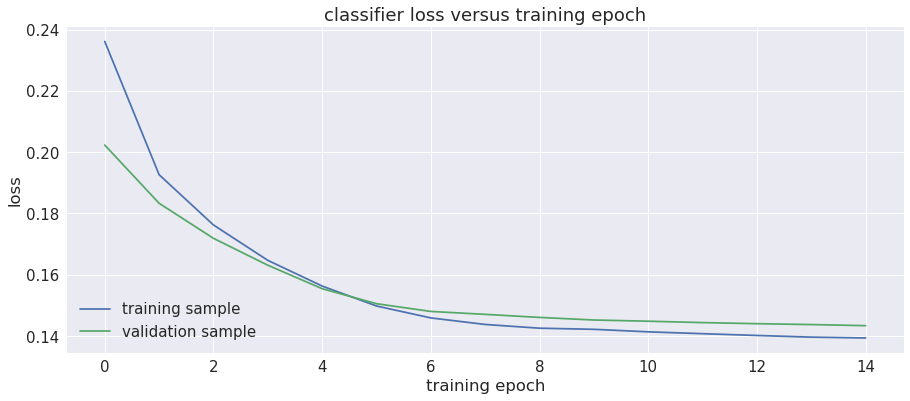

In [11]:
#plot accuracy vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, label='validation sample')
ax.set_title('classifier loss versus training epoch')
ax.set_ylabel('loss')
ax.set_xlabel('training epoch')
ax.legend(loc='lower left')
#ax.set_ylim(0.95*np.min(yp), 1.05*np.max(yp[1:]))
plt.savefig('figs/mlp_loss.png')
print 'final validation loss = ', yp[-1]

In [12]:
#generate class predictions on testing X-O data
N_dots = 20000
df = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
x = df[x_cols].values
y = df[y_cols].values
y_pred = model.predict(x)
for idx in range(len(y_cols)):
    y_col = y_cols[idx]
    df[y_col] = y_pred[:, idx]
idx = (df.O_score > df.X_score) & (df.O_score > df.B_score)
df.loc[idx, 'class_pred'] = 'O'
idx = (df.X_score > df.B_score) & (df.X_score > df.O_score)
df.loc[idx, 'class_pred'] = 'X'
idx = (df.B_score > df.O_score) & (df.B_score > df.X_score)
df.loc[idx, 'class_pred'] = 'B'
df.head(5)

,id,x,y,r,angle,class,X_score,O_score,B_score,class_pred
record,,,,,,,,,,
0,0,-2.913618,-0.683928,2.992813,-2.911032,O,0.310975,0.595210,0.136070,O
1,1,2.318272,1.569160,2.799401,0.595031,O,0.653811,0.334195,0.013519,X
2,2,5.212476,1.776447,5.506875,0.328461,B,0.204461,0.239323,0.526386,B
3,3,-2.506568,0.347416,2.530529,3.003868,O,0.366162,0.598578,0.081899,O
4,4,1.712311,7.977168,8.158874,1.359353,B,-0.019876,-0.015083,1.017541,B


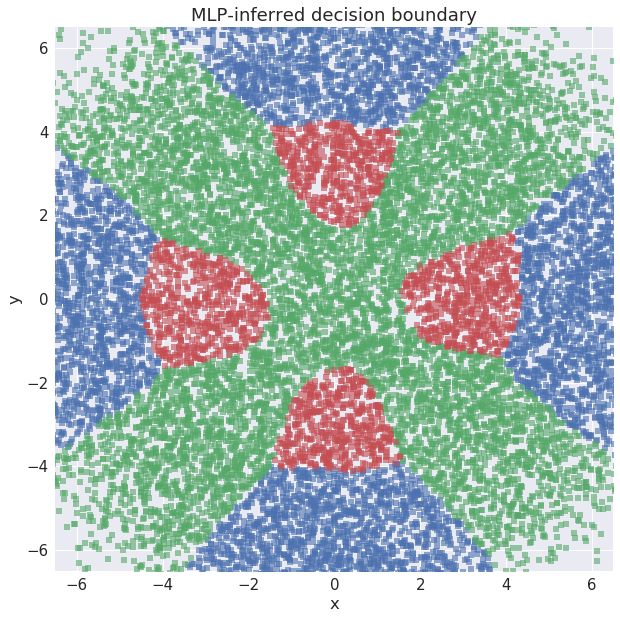

In [13]:
#scatterplot showing model's predicted decision boundaries
xy_rng = (-6.5, 6.5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('MLP-inferred decision boundary')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
plt.savefig('figs/cnet_decision_boundary.png')

In [14]:
#model accuracy
idx = (df['class'] == df['class_pred'])
accuracy = idx.sum()*1.0/len(idx)
print 'model accuracy = ', accuracy

model accuracy =  0.6569


In [15]:
#done
time_stop = tm.time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0

execution time (minutes) =  11.2473924001
